In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.stats


df = pd.read_csv('TuberWeights_13.07.18.csv')
df_soraya = df.loc[df['Variety'] == 'Soraya'].copy()
df_venezia = df.loc[df['Variety'] == 'Venezia'].copy()

df_soraya = df_soraya[['MidSize', 'TuberWeight', 'CubeRoot']]
df_venezia = df_venezia[['MidSize', 'TuberWeight', 'CubeRoot']]

def extract_samples(df, elem='TuberWeight'):
    samples = {}
    for mid_size, tuber_weight in zip(df['MidSize'], df[elem]):
        if mid_size in samples:
            samples[mid_size].append(tuber_weight)
        else:
            samples[mid_size] = [tuber_weight]
    return samples

samples_soraya_w = extract_samples(df_soraya)
samples_soraya_cr = extract_samples(df_soraya, 'CubeRoot')

samples_venezia_w = extract_samples(df_venezia)
samples_venezia_cr = extract_samples(df_venezia, 'CubeRoot')
        
true_dist_soraya = [(x, len(samples_soraya_w[x])) for x in samples_soraya_w]
true_dist_venezia = [(x, len(samples_venezia_w[x])) for x in samples_venezia_w]


In [11]:
def create_batches(list_in, alpha=0, theta=1):
    current_index = 0
    batch_list = []
    
    assert (0 <= alpha and alpha < 1) and theta > -alpha
    for n, weight in enumerate(list_in):
        p = np.random.binomial(1, p=(theta+len(batch_list)*alpha)/(n+theta))
        if(p == 1):
            batch_list.append([weight])
        else:
            probabilities = np.asarray([len(x)-alpha for x in batch_list], dtype='float32')
            probabilities = probabilities/probabilities.sum()
            table = np.random.choice(range(len(batch_list)), 1, p=probabilities)[0]
            batch_list[table].append(weight)
    batch_list = [(len(x), np.sum(x)) for x in batch_list]
    return batch_list

# print(create_batches(samples_soraya_w[17.5], alpha=0.2))

band_to_samples_soraya_w = dict([(x, create_batches(samples_soraya_w[x], alpha=0.2)) for x in samples_soraya_w])
band_to_samples_soraya_cr = dict([(x, create_batches(samples_soraya_cr[x], alpha=0.2)) for x in samples_soraya_cr])

band_to_samples_venezia_w = dict([(x, create_batches(samples_venezia_w[x], alpha=0.2)) for x in samples_venezia_w])
band_to_samples_venezia_cr = dict([(x, create_batches(samples_venezia_cr[x], alpha=0.2)) for x in samples_venezia_cr])


In [12]:
# print(samples_soraya_w)
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct


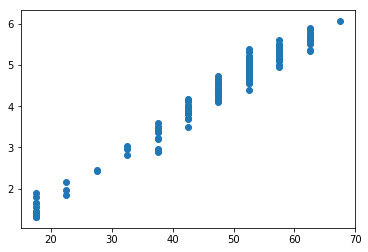

[[0.09416104]] [-0.12352474]


AttributeError: 'GaussianProcessRegressor' object has no attribute 'alpha_'

In [20]:
x = []
y = []
for key in samples_soraya_w:
    x += [key]*len(samples_soraya_w[key])
    y += map(lambda x: x**(1/3), samples_soraya_w[key])
plt.scatter(x,y)
plt.show()

x = np.asarray(x).reshape(-1,1)
y = np.asarray(y).reshape(-1,1)

regr = LinearRegression()
regr.fit(x,y)
print(regr.coef_, regr.intercept_)


x_plt = np.atleast_2d(np.linspace(0, 80, 1000)).T
y_pred, sigma = gp.predict(x_plt, return_std=True)
sigma = sigma.reshape(-1, 1)
plt.scatter(x,y)
plt.plot(x_plt, y_pred, 'b-', label=u'Prediction')
plt.ylim(-5, 10)
plt.fill(np.concatenate([x_plt, x_plt[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),)


plt.show()


In [16]:
def pi_estimate(band_to_samples, smoothing=0):
    pi_sum = {}
    num_potatoes = 0
    for band in band_to_samples:
        total_sum = 0
        for (batch_size, batch_weight) in band_to_samples[band]:
            total_sum += batch_size
        pi_sum[band] = total_sum+smoothing
        num_potatoes += total_sum+smoothing
    pi_dist = {}
    for band in pi_sum:
        pi_dist[band] = pi_sum[band]/num_potatoes
    return pi_dist

def estimate_mu(band_to_samples):
    mu = {}
    for band in band_to_samples:
        total_weight = 0
        total_potatoes = 0
        for (batch_size, batch_weight) in band_to_samples[band]:
            total_weight += batch_weight
            total_potatoes += batch_size
        mu[band] = total_weight/total_potatoes
    return mu

def estimate_var(band_to_samples, mu_estimate):
    var = {}
    for band in band_to_samples:
        square_diff_sum = 0 
        for (batch_size, batch_weight) in band_to_samples[band]:
            square_diff_sum += (batch_weight - batch_size*mu_estimate[band])**2/batch_size
        var[band] = max(square_diff_sum/len(band_to_samples[band]), 1e-2)
    return var


def get_posterior(weight, band_to_samples, pi_estimate, mu_estimate, var_estimate):
    post_prop = {}
    sum_post = 0
    post = {}
    for band in band_to_samples:
        norm_dist = scipy.stats.norm(mu_estimate[band], var_estimate[band]**(1/2))
        post_prop[band] = norm_dist.pdf(weight)*pi_estimate[band]
        sum_post += post_prop[band]

    for band in post_prop:
        post[band] = post_prop[band]/sum_post
    return post

def get_argmax(posterior):
    key_max = None
    max_value = 0.0
    for band in posterior:
        if posterior[band] > max_value:
            max_value = posterior[band]
            key_max = band
    return key_max

def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def calculate_KL(y_pred, y_true):
    y_pred = dict(y_pred)
    y_true = dict(y_true)
    
    y_pred_dist = []
    y_true_dist = []
    
    for i in y_pred:
        y_pred_dist.append(y_pred[i])
        y_true_dist.append(y_true[i])
        
    y_pred_dist = np.asarray(y_pred_dist)
    y_pred_dist = y_pred_dist/y_pred_dist.sum()
    
    y_true_dist = np.asarray(y_true_dist)
    y_true_dist = y_true_dist/y_true_dist.sum()
    
    return kl(y_true_dist, y_pred_dist)

def calculate_W(y_pred, y_true):
    y_pred = dict(y_pred)
    y_true = dict(y_true)
    
    y_pred_dist = []
    y_true_dist = []
    
    for i in y_pred:
        y_pred_dist.append(y_pred[i])
        y_true_dist.append(y_true[i])
        
    y_pred_dist = np.asarray(y_pred_dist)
    y_pred_dist = y_pred_dist/y_pred_dist.sum()
    
    y_true_dist = np.asarray(y_true_dist)
    y_true_dist = y_true_dist/y_true_dist.sum()
    
    return scipy.stats.wasserstein_distance(y_true_dist, y_pred_dist)



In [17]:
def get_pseudo_counts(band_to_samples, count_df):
    pi = pi_estimate(band_to_samples, smoothing=0)
    mu = estimate_mu(band_to_samples)
    var = estimate_var(band_to_samples, mu)
    
    potato_counts = {}

    for weight in count_df:
        posterior = get_posterior(weight, band_to_samples, pi, mu, var)
        for band in posterior:
            if band in potato_counts:
                potato_counts[band]+= posterior[band]
            else:
                potato_counts[band] = posterior[band]
    return potato_counts

In [18]:
pseudo_v_w = get_pseudo_counts(band_to_samples_venezia_w, df_venezia['TuberWeight'])
pseudo_v_cr = get_pseudo_counts(band_to_samples_venezia_cr, df_venezia['CubeRoot'])

print('True Distribution : \n', dict(true_dist_venezia))
print()
print('Estimated distribution based on TuborWeight :\n', pseudo_v_w)
print('KL Divergence of categorical distribution :\n', calculate_KL(pseudo_v_w, true_dist_venezia))
print('W Distance of categorical distribution :\n', calculate_W(pseudo_v_w, true_dist_venezia))
print()
print('Estimated distribution based on CubeRoot :\n', pseudo_v_cr)
print('KL Divergence of categorical distribution :\n', calculate_KL(pseudo_v_cr, true_dist_venezia))
print('W Distance of categorical distribution :\n', calculate_W(pseudo_v_cr, true_dist_venezia))

True Distribution : 
 {32.5: 54, 17.5: 28, 37.5: 63, 22.5: 59, 42.5: 25, 27.5: 72, 47.5: 2}

Estimated distribution based on TuborWeight :
 {32.5: 47.959192122322094, 17.5: 22.42807041430295, 37.5: 64.22280774780272, 22.5: 68.53141808397011, 42.5: 26.173422730695073, 27.5: 71.57400661492703, 47.5: 2.1110822859800504}
KL Divergence of categorical distribution :
 0.005758983460866175


AttributeError: module 'scipy.stats' has no attribute 'wasserstein_distance'

In [ ]:
for x in pseudo_v_w:
    print(round(pseudo_v_cr[x],2))

In [ ]:
pseudo_s_w = get_pseudo_counts(band_to_samples_soraya_w, df_soraya['TuberWeight'])
pseudo_s_cr = get_pseudo_counts(band_to_samples_soraya_cr, df_soraya['CubeRoot'])

print('True Distribution : \n', dict(true_dist_soraya))
print()
print('Estimated distribution based on TuborWeight :\n', pseudo_s_w)
print('KL Divergence of categorical distribution :\n', calculate_KL(pseudo_s_w, true_dist_soraya))
print('W Distance of categorical distribution :\n', calculate_W(pseudo_s_w, true_dist_soraya))

print()
print('Estimated distribution based on CubeRoot :\n', pseudo_s_cr)
print('KL Divergence of categorical distribution :\n', calculate_KL(pseudo_s_cr, true_dist_soraya))
print('W Distance of categorical distribution :\n', calculate_W(pseudo_s_cr, true_dist_soraya))


9.34
4.64
2.02
3.92
13.24
15.05
41.88
35.98
25.63
12.24
1.06
